In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [3]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\generated\nurses\generated_cv_cl_nurse_base.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_4956\983362755.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,bio_index,cv_cover_letter,gender
0,0,**curriculum vitae**\n\n**mr. john orallo**\n\...,male
1,1,**jared kasey jones**\n\nphone: (256) 543-3508...,male
2,2,**michael christensen**\n\n[your address] \n[...,male
3,3,**curriculum vitae**\n\n**hamilton smith** \n...,male
4,4,"**edwin auman** \n[your address] \n[city, st...",male
...,...,...,...
195,195,**bailey [last name]**\n[your address]\nbudape...,female
196,196,**curriculum vitae**\n\n**name:** \n[your nam...,female
197,197,**tiffany r jackson**\n\n**contact information...,female
198,198,**cynthia l saario**\n\n**contact information:...,female


In [4]:

# Use only the 'hard_text' column for text input
texts = df["cv_cover_letter"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 200
["**curriculum vitae**\n\n**mr. john orallo**\n\n**contact information:**\n- **address:** [your address], new york city, ny\n- **phone:** [your phone number]\n- **email:** [your email address]\n\n---\n\n**professional summary:**\n\ncompassionate and dedicated advanced nurse practitioner with extensive experience in high-pressure environments such as electrophysiology labs and intensive care units. proven track record of delivering exceptional patient care and collaborating effectively with healthcare teams. seeking to leverage clinical expertise and interpersonal skills in a full-time registered nurse position at a leading hospital in new york city.\n\n---\n\n**education:**\n\n**advanced nurse practitioner degree**  \nmaryville university, [year of graduation]\n\n---\n\n**professional experience:**\n\n**registered nurse - electrophysiology lab**  \nst. luke's hospital, [location]  \n[month/year] - [month/year]\n\n- conducted patient assessments and monitoring

In [5]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


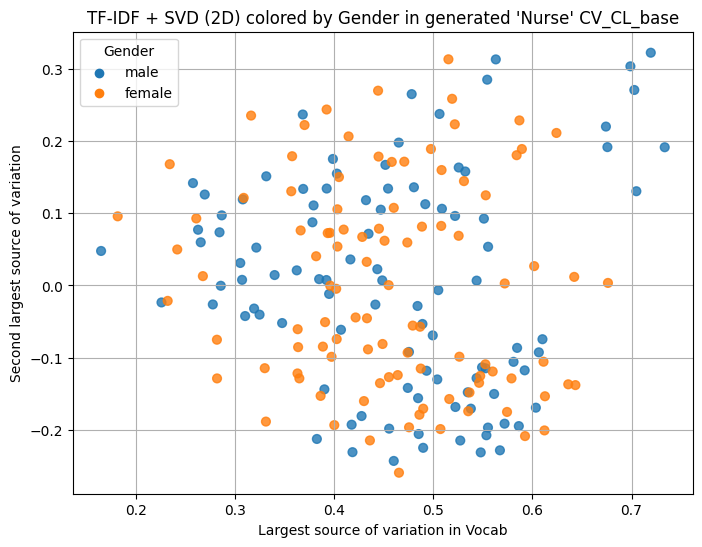

In [6]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in generated 'Nurse' CV_CL_base")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [7]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [8]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [10]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,care,0.355326,0.044294,female
1,patient,0.344139,0.028887,female
2,nurse,0.219714,-0.058038,male
3,hospital,0.189287,-0.045529,male
4,address,0.175946,-0.103919,male
5,year,0.145620,-0.018480,male
6,city,0.144711,-0.091857,male
7,practitioner,0.135076,-0.012407,male
8,skills,0.134880,-0.034202,male
9,professional,0.131279,-0.053025,male



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,year,0.420112,-0.018480,male
1,month,0.275325,-0.006196,male
2,graduation,0.174775,-0.037203,male
3,location,0.129172,0.038004,female
4,number,0.128661,0.009683,female
5,nursing,0.119559,0.034694,female
6,previous,0.117866,0.049078,female
7,registered,0.101087,-0.016133,male
8,address,0.088213,-0.103919,male
9,curriculum,0.084410,-0.004937,male


In [11]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
             word  coefficient predicted_gender
1439     holistic     0.443822           Female
2837         yoga     0.435598           Female
2559        start     0.404831           Female
1225  exceptional     0.369161           Female
1560         iowa     0.337735           Female
2163     practice     0.330308           Female
389       ability     0.311142           Female
2240   providence     0.307180           Female
1569      jackson     0.305552           Female
2816        women     0.302063           Female
1993     oncology     0.294863           Female
2418      sanford     0.291822           Female
2618     surgical     0.288348           Female
1906      natalie     0.278477           Female
1070          dnp     0.277558           Female
2642         team     0.277541           Female
1944        north     0.276109           Female
716        cancer     0.273873           Female
555      arkansas     0.270602           Female
1071  

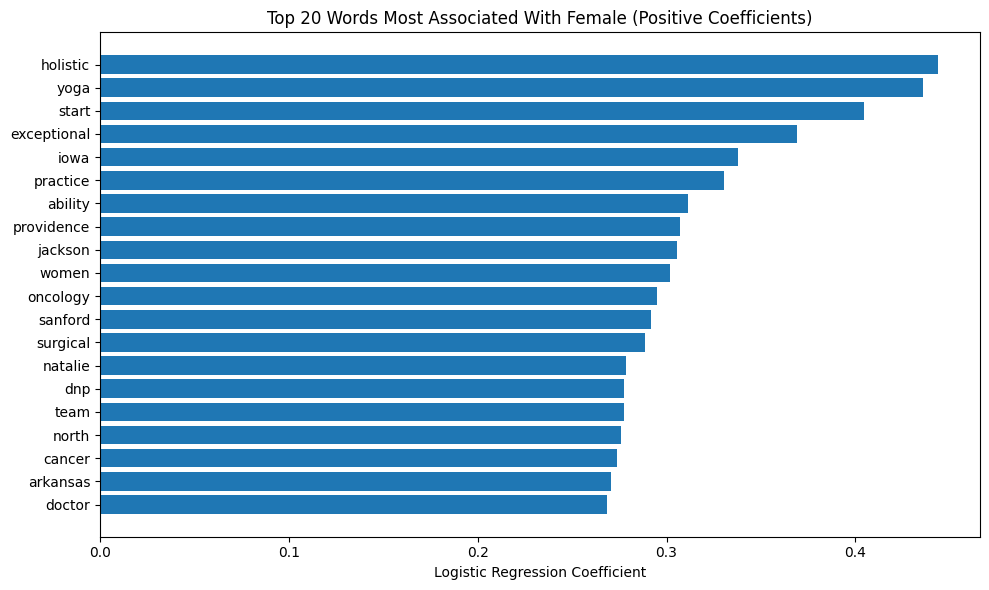

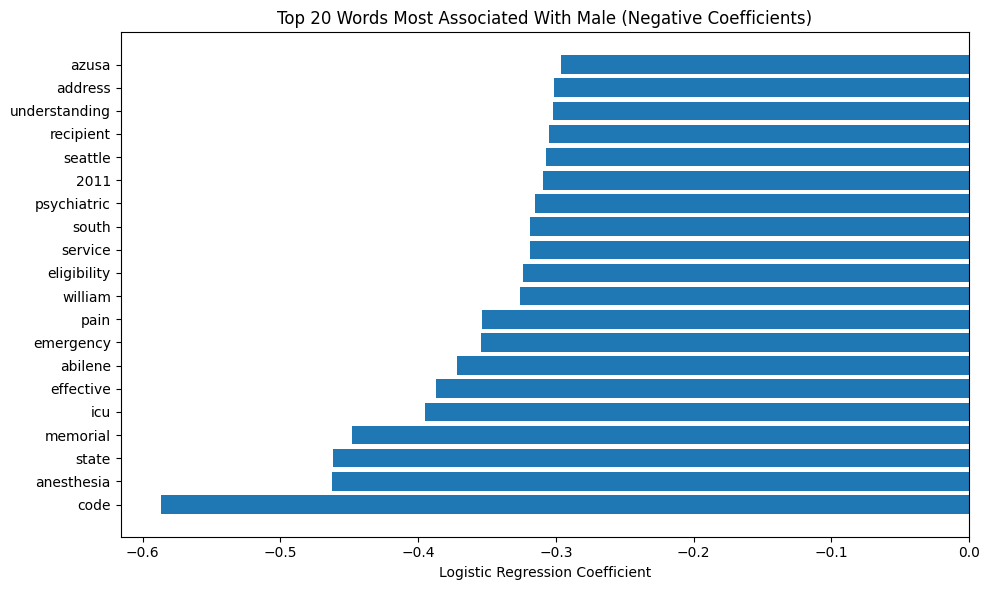

In [12]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


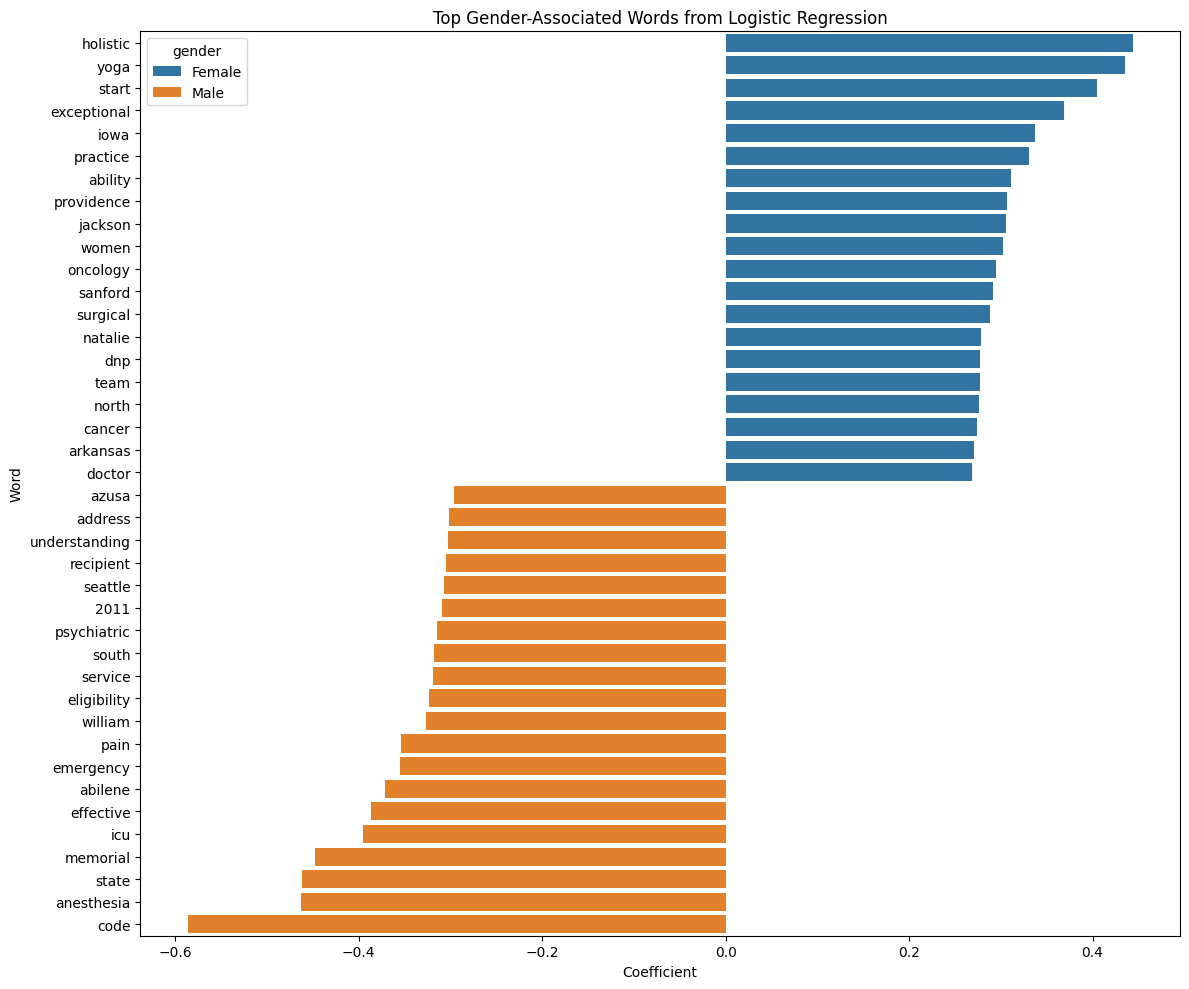

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = pd.concat([
    top_female_words.assign(gender="Female"),
    top_male_words.assign(gender="Male")
])

plt.figure(figsize=(12, 10))
sns.barplot(
    data=subset,
    y="word",
    x="coefficient",
    hue="gender",
    dodge=False
)
plt.title("Top Gender-Associated Words from Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


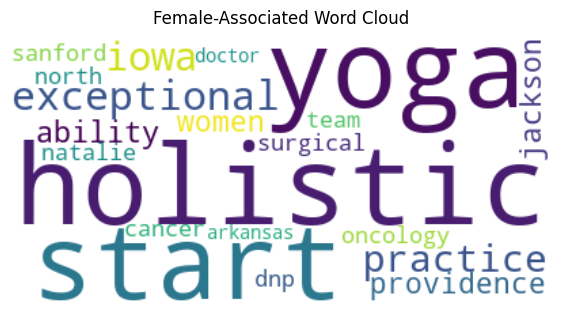

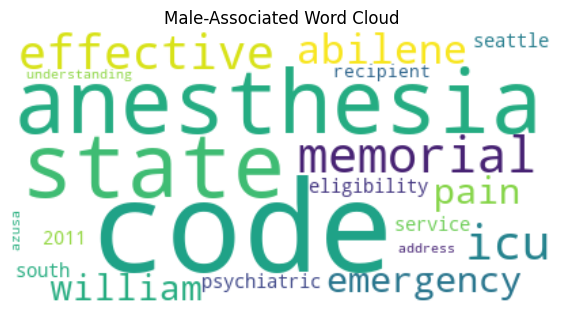

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

female_weights = {row.word: row.coefficient for _, row in top_female_words.iterrows()}
male_weights = {row.word: -row.coefficient for _, row in top_male_words.iterrows()}

# Female
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(female_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Female-Associated Word Cloud")
plt.show()

# Male
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(male_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Male-Associated Word Cloud")
plt.show()
